# Fonctions de base

In [12]:
import pandas as pd
import gurobipy
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

def load_data():
    """Charge les données à partir des fichiers CSV."""
    brick_index_value = pd.read_csv('./bricks_index_values.csv')
    brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')
    bricks = brick_index_value['brick'].tolist()
    reps = list(range(1, 5))  # 4 représentants

    distances = {
        row['brick']: [row[f'rp{i}'] for i in reps]
        for _, row in brick_rp_distances.iterrows()
    }
    
    index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

    return bricks, reps, distances, index_values

def setup_model_minimize_distance(bricks, reps, distances, index_values, L=0.8, U=1.2):
    """Crée et configure le modèle Gurobi pour minimiser la distance."""
    model = Model("Minimize_Distance")

    # Variables de décision
    x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")

    # Fonction objectif : minimiser la distance totale
    model.setObjective(
        quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
    )

    # Contraintes : chaque brique est assignée à un seul représentant
    model.addConstrs(
        (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
    )

    # Contraintes de charge de travail dans l'intervalle [L, U]
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
    )
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
    )

    return model, x

def setup_model_minimize_disruption(bricks, reps, index_values, initial_assignment, L=0.8, U=1.2):
    """Crée et configure le modèle Gurobi pour minimiser la perturbation."""
    model = Model("Minimize_Disruption")

    # Variables de décision
    x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
    y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

    # Fonction objectif : minimiser la perturbation pondérée par l'index
    model.setObjective(
        quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
    )

    # Contraintes : chaque brick doit être attribué à un seul représentant
    model.addConstrs(
        (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
    )

    # Contraintes de charge de travail dans l'intervalle [L, U]
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
    )
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
    )

    # Mesurer la perturbation
    model.addConstrs(
        (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
         for b in bricks for r in reps), name="Disruption"
    )

    return model, x, y

def solve_model(model):
    """Résout le modèle d'optimisation."""
    model.optimize()

    if model.Status == GRB.OPTIMAL:
        print("\nSolution optimale trouvée :", model.ObjVal)
        return True
    else:
        print("\nLe modèle n'a pas trouvé de solution optimale.")
        return False

def extract_results(bricks, reps, x):
    """Extrait les résultats du modèle et retourne un DataFrame."""
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])
    return results_df

def plot_pareto_solutions(non_dominated_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _ in non_dominated_solutions):
        subset = [(d, dis) for (lb, ub, d, dis) in non_dominated_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

def epsilon_constraint_scheme(
    initial_assignment,
    max_distance,
    workload,
    bricks,
    reps,
    distances,
    index_values,
):
    """Calcule les solutions Pareto en utilisant la méthode des contraintes epsilon."""
    solutions = []
    epsilon_step = 1  # Pas pour réduire epsilon

    # Déballer directement le tuple workload
    L, U = workload
    print(f"\nSolving for workload constraints: [{L}, {U}]")
    epsilon = max_distance  # Réinitialiser epsilon pour cette configuration de workload

    while epsilon >= 0:
        # Création du modèle
        model = Model("Epsilon_Constraint")

        # Variables de décision
        x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
        y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

        # Objectif : minimiser la perturbation
        total_distance = quicksum(
            distances[b][r - 1] * x[b, r] for b in bricks for r in reps
        )
        total_disruption = quicksum(
            index_values[b] * y[b, r] for b in bricks for r in reps
        )
        model.setObjective(total_disruption, GRB.MINIMIZE)

        # Contraintes
        model.addConstrs(
            (quicksum(x[b, r] for r in reps) == 1 for b in bricks),
            name="AssignEachBrick",
        )
        model.addConstr(total_distance <= epsilon, name="Epsilon_Distance")
        model.addConstrs(
            (
                y[b, r] >= x[b, r] - (1 if initial_assignment.get(b, None) == r else 0)
                for b in bricks
                for r in reps
            ),
            name="Disruption",
        )
        model.addConstrs(
            (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps),
            name="MinWorkload",
        )
        model.addConstrs(
            (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps),
            name="MaxWorkload",
        )

        # Résolution du modèle
        model.optimize()

        # Stocker les solutions si optimales
        if model.Status == GRB.OPTIMAL:
            solution_distance = total_distance.getValue()
            solution_disruption = total_disruption.getValue()
            solutions.append((L, U, solution_distance, solution_disruption))
            print(
                f"Solution found: Distance = {solution_distance}, Disruption = {solution_disruption}"
            )
        else:
            print(f"No feasible solution for epsilon = {epsilon}")

        # Réduire epsilon
        epsilon -= epsilon_step

    return solutions


def filter_non_dominated_solutions(solutions):
    """Filter non-dominated solutions from a list of solutions."""
    non_dominated = []
    for s in solutions:
        dominated = False
        for other in solutions:
            if other != s and other[2] <= s[2] and other[3] <= s[3] and (other[2] < s[2] or other[3] < s[3]):
                dominated = True
                break
        if not dominated:
            non_dominated.append(s)
    return non_dominated
    

# Epsilon-constraint


Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x00392e93
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]


  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 1.8370000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.13770    0    2    1.83700    0.13770  92.5%     -    0s
H    0     0                       0.2529000    0.13770  45.6%     -    0s
H    0     0                       0.2383000    0.13770  42.2%     -    0s
H    0     0                       0.1803000    0.13770  23.6%     -    0s
H    0     0                       0.1696000    0.13770  18.8%     -    0s
     0     0    0.13770    0    2    0.16960    0.13770  18.8%     -    0s

Explored 1 nodes (30 simplex iterations) in 0.12 seconds (0.00 work un

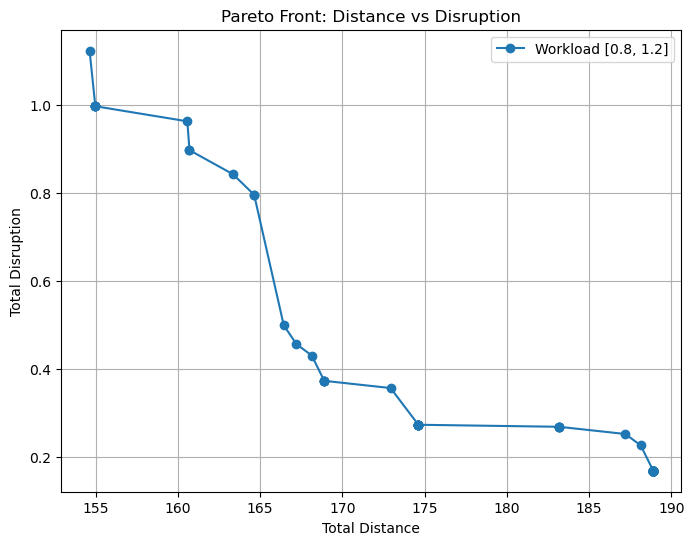


Solving for workload constraints: [0.85, 1.15]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0xb2d6e21c
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 2.0775000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.877000e-01, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

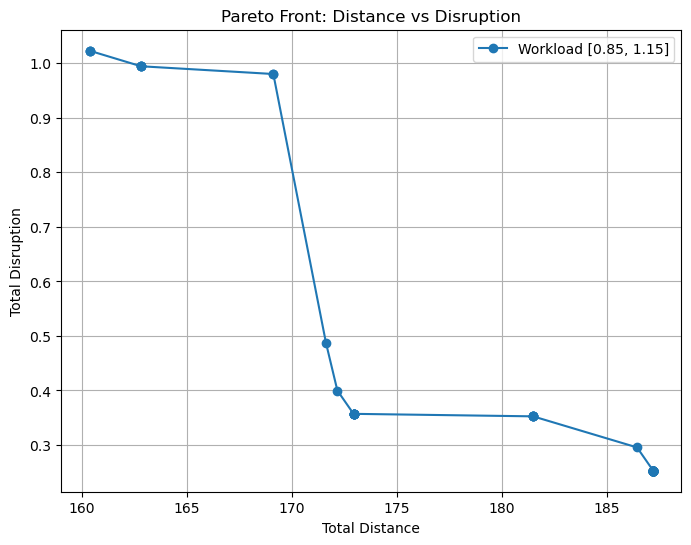


Solving for workload constraints: [0.9, 1.1]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0xcd8f5709
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+02]
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 0.4652000

Root relaxation: objective 2.377000e-01, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

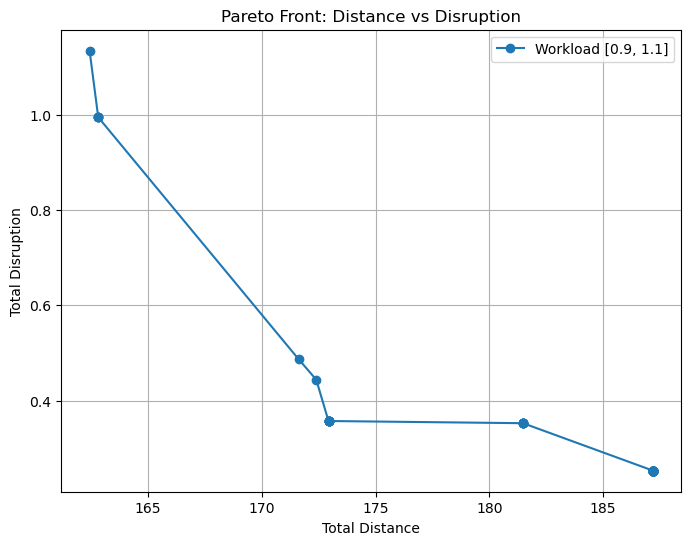

In [13]:
# Charger les données
bricks, reps, distances, index_values = load_data()
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]  # Exemple correct

# Initial assignment
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}


for workload in workload_bounds:
    # Compute Pareto solutions
    max_distance = sum(distances[b][0] for b in bricks)  # Initial large distance
    pareto_solutions = epsilon_constraint_scheme(initial_assignment, max_distance, workload, bricks, reps, distances, index_values)

    # Filter non-dominated solutions
    non_dominated_solutions = filter_non_dominated_solutions(pareto_solutions)

    # Print the set of non-dominated solutions
    print("\nSet of Non-Dominated Solutions:")
    for L, U, distance, disruption in non_dominated_solutions:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    # Plot the Pareto front
    plot_pareto_solutions(non_dominated_solutions)

## Instance 10-100

170

Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1121 rows, 2000 columns and 5990 nonzeros
Model fingerprint: 0x6f80316b
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 9.9142000
Presolve removed 1001 rows and 1000 columns
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 9.275100e+00, 184 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

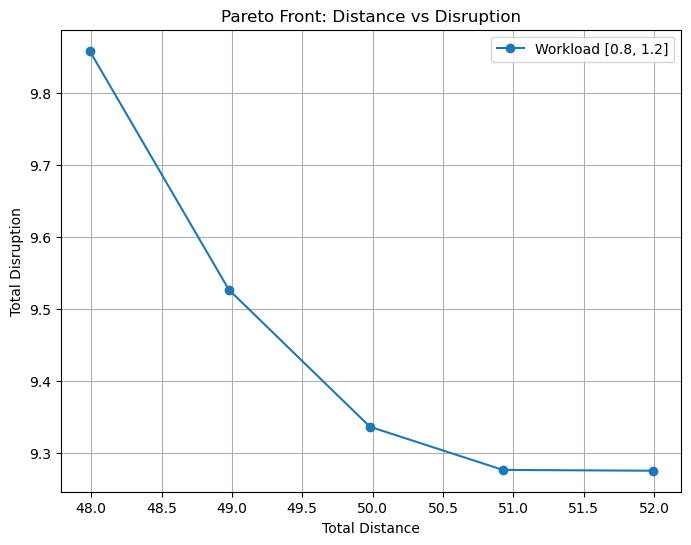

170

Solving for workload constraints: [0.85, 1.15]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1121 rows, 2000 columns and 5990 nonzeros
Model fingerprint: 0xce1dac50
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 9.9142000
Presolve removed 1001 rows and 1000 columns
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 9.275100e+00, 183 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

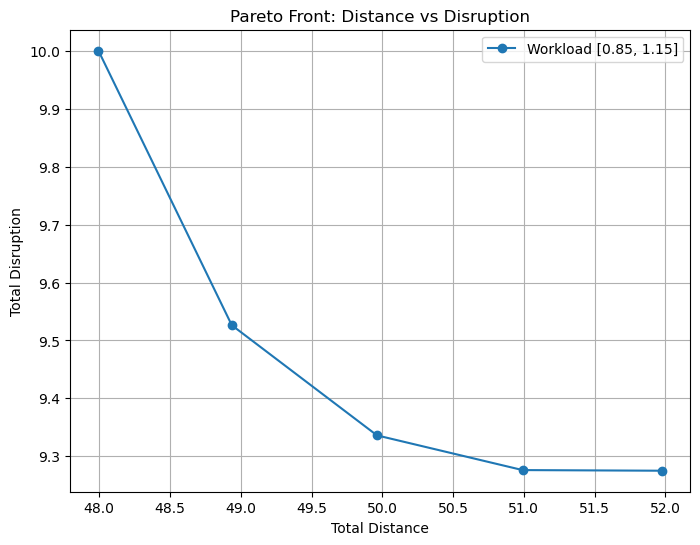

170

Solving for workload constraints: [0.9, 1.1]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1121 rows, 2000 columns and 5990 nonzeros
Model fingerprint: 0xf5f248eb
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+02]
Found heuristic solution: objective 9.9142000
Presolve removed 1001 rows and 1000 columns
Presolve time: 0.01s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 9.275100e+00, 171 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

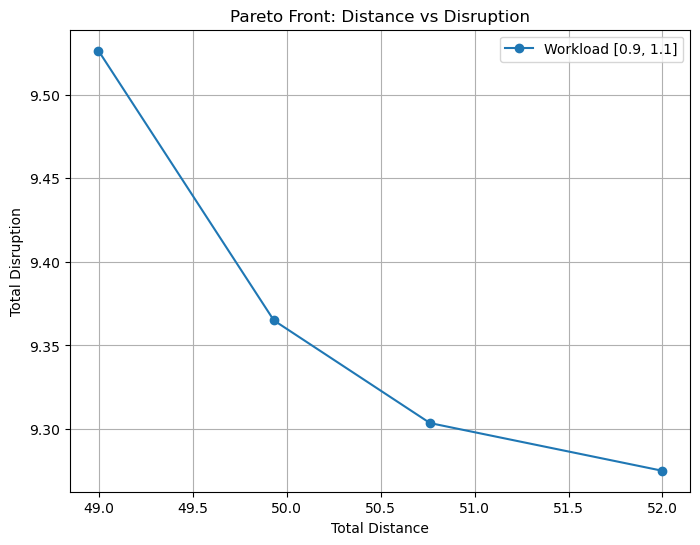

In [14]:
from scipy.spatial.distance import pdist, squareform

# Charger les données
data = pd.read_csv('./Pfitzer10-100.csv', sep=';', decimal=',')
data.columns = [
    "zone", "x", "y", "workload_index", "current_office",
    "rp1", "rp2", "rp3", "rp4", "rp5", "rp6", "rp7", "rp8", "rp9", "rp10"
]

# Extraire les zones et représentants
bricks = data["zone"].tolist()
reps = list(range(1, 11))

# Calcul des distances entre chaque zone et les bureaux actuels des représentants
rep_positions = data[data["current_office"] == 1][["zone", "x", "y"]].set_index("zone")
coords = data[["x", "y"]].values
distances_matrix = squareform(pdist(coords))  # Matrice des distances

# Recalcul des distances entre chaque zone et les représentants
distances = {
    zone: [distances_matrix[zone - 1, rep - 1] for rep in reps]
    for zone in bricks
}

# Dictionnaire des index de charge de travail
index_values = dict(zip(data["zone"], data["workload_index"]))

# Assignation initiale des zones aux représentants
initial_assignment_new_instance = {
    zone: data.loc[data['zone'] == zone, 'current_office'].values[0] for zone in bricks
}

# Calculer les solutions Pareto
for workload in workload_bounds:
    # initialiser la distance maximale totale 
    max_distance = 170
    print(max_distance)
    pareto_solutions = epsilon_constraint_scheme(initial_assignment_new_instance, max_distance, workload, bricks, reps, distances, index_values)

    # Filtrer les solutions non dominées
    non_dominated_solutions = filter_non_dominated_solutions(pareto_solutions)

    # Afficher l'ensemble des solutions non dominées
    print("\nSet of Non-Dominated Solutions:")
    for L, U, distance, disruption in non_dominated_solutions:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    # Tracer le front de Pareto
    plot_pareto_solutions(non_dominated_solutions)


## Assigning multiple SRs to zones 

1.3428758728936938
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1021 rows, 2000 columns and 4990 nonzeros
Model fingerprint: 0xbd7676cd
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 1010 rows and 1976 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

Le modèle n'a pas trouvé de solution optimale.

Set of Non-Dominated Solutions (Partial Assignment with Disruption):


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_40068\4247004406.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


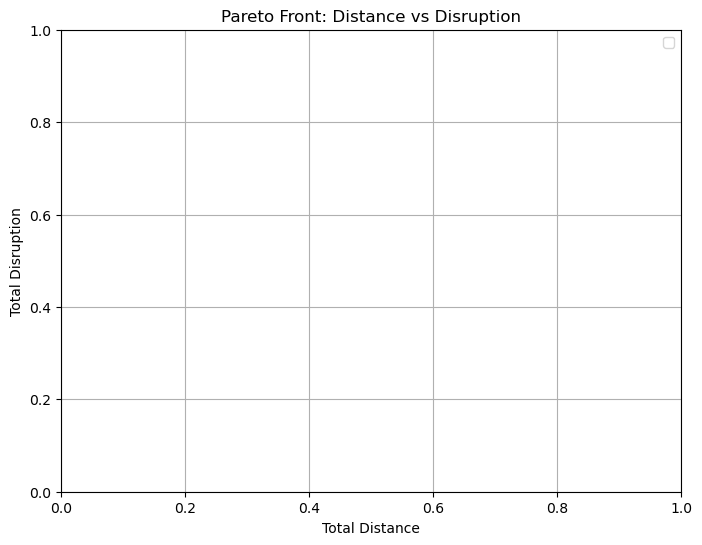

1.3428758728936938
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1021 rows, 2000 columns and 4990 nonzeros
Model fingerprint: 0x5ed22e25
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 1010 rows and 1878 columns
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

Le modèle n'a pas trouvé de solution optimale.

Set of Non-Dominated Solutions (Partial Assignment with Disruption):


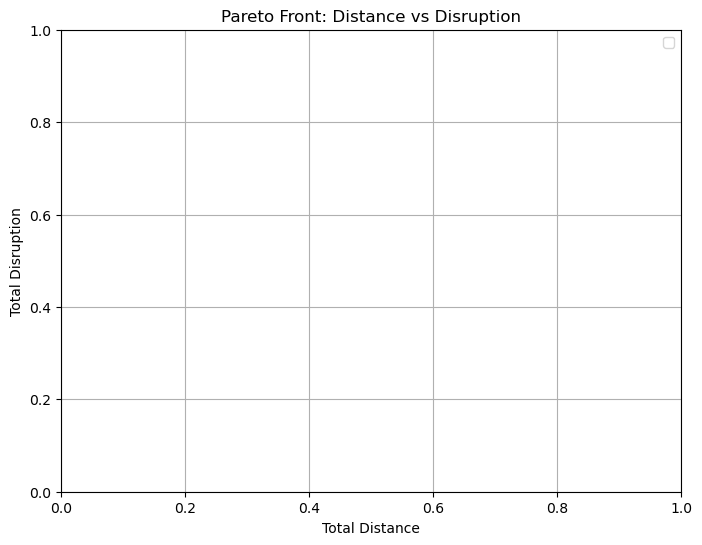

1.3428758728936938
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1021 rows, 2000 columns and 4990 nonzeros
Model fingerprint: 0x071d0c5b
Variable types: 0 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-03, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+00]
Presolve removed 1010 rows and 1911 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

Le modèle n'a pas trouvé de solution optimale.

Set of Non-Dominated Solutions (Partial Assignment with Disruption):


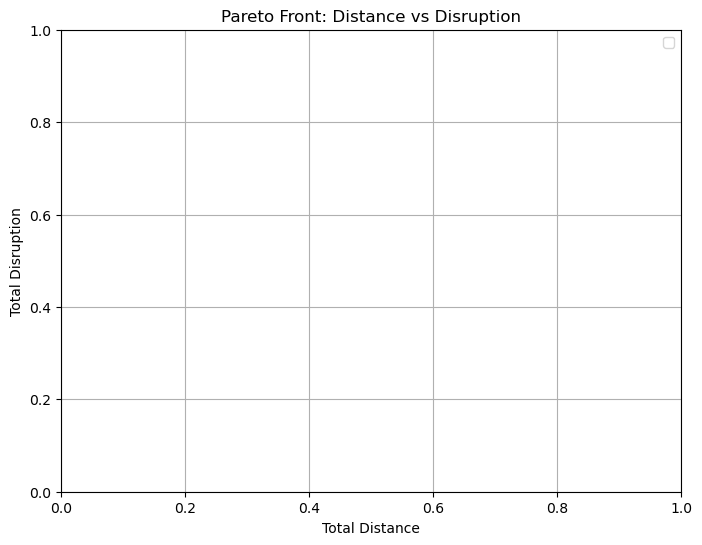

In [15]:
def setup_model_partial_assignment_with_disruption(bricks, reps, distances, index_values, initial_assignment, L=0.8, U=1.2):
    """Crée et configure le modèle Gurobi pour minimiser la perturbation avec assignation partielle."""
    model = Model("Partial_Assignment_With_Disruption")

    # Variables de décision
    x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
    y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

    # Fonction objectif : minimiser la perturbation pondérée par l'index
    model.setObjective(
        quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
    )

    # Contraintes : chaque brique peut être assignée à plusieurs représentants
    # Pas de contrainte d'assignation unique ici

    # Contraintes de charge de travail dans l'intervalle [L, U]
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
    )
    model.addConstrs(
        (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
    )

    # Mesurer la perturbation
    model.addConstrs(
        (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
         for b in bricks for r in reps), name="Disruption"
    )

    return model, x, y

def epsilon_constraint_scheme_partial(initial_assignment, max_distance, workload, bricks, reps, distances, index_values):
    """Compute Pareto solutions using the epsilon-constraint method for partial assignment with disruption."""
    L, U = workload
    pareto_solutions = []

    for epsilon in range(int(max_distance), 0, -1):
        model, x, y = setup_model_partial_assignment_with_disruption(bricks, reps, distances, index_values, initial_assignment, L, U)
        model.addConstr(quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps) <= epsilon, name="EpsilonConstraint")
        if solve_model(model):
            total_distance = sum(distances[b][r - 1] * x[b, r].X for b in bricks for r in reps)
            total_disruption = sum(index_values[b] * y[b, r].X for b in bricks for r in reps)
            pareto_solutions.append((L, U, total_distance, total_disruption))

    return pareto_solutions

# Calculer les solutions Pareto pour l'assignation partielle avec perturbation
for workload in workload_bounds:
    # initialiser la distance maximale totale 
    max_distance = max(distances[b][0] for b in bricks)
    print(max_distance)
    pareto_solutions_partial = epsilon_constraint_scheme_partial(initial_assignment_new_instance, max_distance, workload, bricks, reps, distances, index_values)

    # Filtrer les solutions non dominées
    non_dominated_solutions_partial = filter_non_dominated_solutions(pareto_solutions_partial)

    # Afficher l'ensemble des solutions non dominées
    print("\nSet of Non-Dominated Solutions (Partial Assignment with Disruption):")
    for L, U, distance, disruption in non_dominated_solutions_partial:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    # Tracer le front de Pareto
    plot_pareto_solutions(non_dominated_solutions_partial)


## Adding a new SRs

In [16]:
import numpy as np
# Increase the demand uniformly by 25%
for brick in index_values:
    index_values[brick] *= 1.25

# Add a new sales representative
new_reps = reps + [11]

# Update distances to include the new sales representative
for brick in bricks:
    distances[brick].append(np.linalg.norm(coords[brick - 1] - coords[optimal_brick - 1]))

# Determine the optimal location for the new sales representative's office
def find_optimal_location(coords, bricks):
    # Calculate the centroid of all brick coordinates
    centroid = coords.mean(axis=0)
    # Find the brick closest to the centroid
    distances_to_centroid = np.linalg.norm(coords - centroid, axis=1)
    optimal_brick = bricks[np.argmin(distances_to_centroid)]
    return optimal_brick

optimal_brick = find_optimal_location(coords, bricks)
print(f"The optimal location for the new sales representative's office is at brick {optimal_brick}.")

# Update initial assignment to include the new sales representative
initial_assignment_new_instance[optimal_brick] = 11

# Solve the model with the new sales representative
for workload in workload_bounds:
    max_distance = 170
    pareto_solutions = epsilon_constraint_scheme(initial_assignment_new_instance, max_distance, workload, bricks, new_reps, distances, index_values)

    non_dominated_solutions = filter_non_dominated_solutions(pareto_solutions)

    print("\nSet of Non-Dominated Solutions with New Sales Representative:")
    for L, U, distance, disruption in non_dominated_solutions:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    plot_pareto_solutions(non_dominated_solutions)

# Find the optimal location for the new sales representative's office
def find_optimal_location(coords, bricks, distances, index_values, reps, initial_assignment):
    best_location = None
    min_disruption = float('inf')
    min_distance = float('inf')

    for brick in bricks:
        # Temporarily assign the new SR to this brick
        temp_assignment = initial_assignment.copy()
        temp_assignment[brick] = 11

        # Solve the model with the temporary assignment
        model, x, y = setup_model_minimize_disruption(bricks, reps + [11], index_values, temp_assignment, L, U)
        model.addConstr(quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps + [11]) <= max_distance, name="EpsilonConstraint")
        if solve_model(model):
            total_distance = sum(distances[b][r - 1] * x[b, r].X for b in bricks for r in reps + [11])
            total_disruption = sum(index_values[b] * y[b, r].X for b in bricks for r in reps + [11])

            # Check if this location is better
            if total_disruption < min_disruption or (total_disruption == min_disruption and total_distance < min_distance):
                min_disruption = total_disruption
                min_distance = total_distance
                best_location = brick

    return best_location

optimal_brick = find_optimal_location(coords, bricks, distances, index_values, reps, initial_assignment_new_instance)
print(f"The optimal location for the new sales representative's office is at brick {optimal_brick}.")

# Update initial assignment to include the new sales representative
initial_assignment_new_instance[optimal_brick] = 11

# Solve the model with the new sales representative
for workload in workload_bounds:
    max_distance = 170
    pareto_solutions = epsilon_constraint_scheme(initial_assignment_new_instance, max_distance, workload, bricks, new_reps, distances, index_values)

    non_dominated_solutions = filter_non_dominated_solutions(pareto_solutions)

    print("\nSet of Non-Dominated Solutions with New Sales Representative:")
    for L, U, distance, disruption in non_dominated_solutions:
        print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

    plot_pareto_solutions(non_dominated_solutions)

NameError: name 'optimal_brick' is not defined